In [1]:
from PIL import Image
import seaborn as sns
import numpy as np
import matplotlib.patches as patches
import pandas as pd
from typing import NamedTuple

In [2]:
binary_raw = Image.open("blob_rect_binary_input.png")

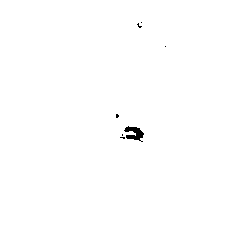

In [3]:
binary_raw

In [4]:
binary = np.array(binary_raw)

In [5]:
class Overlap(NamedTuple):
    overlapping: bool
    tlx: int
    tly: int
    brx: int
    bry: int

def rect_overlap(r1, r2) -> Overlap:
    merged_tlx = max(r1[0], r2[0])
    merged_tly = max(r1[1], r2[1])
    merged_brx = min(r1[2], r2[2])
    merged_bry = min(r1[3], r2[3])

    if merged_tlx > merged_brx or merged_tly > merged_bry:
        overlap = False
    else:
        overlap = True
    
    return Overlap(
        overlapping=overlap,
        tlx=merged_tlx,
        tly=merged_tly,
        brx=merged_brx,
        bry=merged_bry
    )


In [6]:
# Take an array of sorted numbers (or probably any comparable values)
# and return a new array with the indexes which represent the
# the starts of continuous values in the input array.  The last element
# in the returned array will always be None for use in slicing where
# it will slice all the way to the end of the array.
# ex:
# a = [1,2,3,9,10,10,10,11,17,18,19]
# group_starts(a) -> [0, 2, 3, 7, 8, None]
def group_starts(a):
    if len(a) == 1:
        return np.array([0,1])
    shifted = np.array(list(zip(a[-len(a):], a[-len(a)+1:])))
    res = np.array([i for i in map(lambda x: x[1] in (x[0], x[0]+1), shifted)])
    # rest is based on https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
    cuts = np.empty(len(res), dtype=bool)
    cuts[0] = True
    np.not_equal(res[:-1], res[1:], out=cuts[1:])
    starts = np.nonzero(cuts)[0]
    return np.append(starts, None)

In [7]:
# Get all zero points in the image (working with a negative image)
# then sort the points on the _X_ coordinate and then split into separate
# aligned lists of the X and Y coords.
ret = np.argwhere(binary == 0)
ret = np.array(sorted(list(map(tuple, ret)), key=lambda x:x[0]))
y = np.squeeze(np.hsplit(ret, 2)[0])
x = np.squeeze(np.hsplit(ret, 2)[1])

In [8]:
# Y axis rectangles
# For each contiguous set of Y coords, iterate over each
# contiguous set of X cords.  The min/max of the Xs and Ys form
# the rectangles.
box_points = []
y_starts = group_starts(y)
ys_prev = 0
for ys in y_starts:
    g = sorted(x[ys_prev:ys])
    if not len(g):
        continue
    miny = min(y[ys_prev:ys])
    maxy = max(y[ys_prev:ys])
    if ys is not None:
        ys_prev = ys+1
    x_starts = group_starts(g)
    xs_prev = 0
    for xs in x_starts:
        gsub = g[xs_prev:xs]
        if not len(gsub):
            continue
        minx = min(gsub)
        maxx = max(gsub)
        box_points.append((minx, miny, maxx, maxy))
        if xs is not None:
            xs_prev = xs+1

In [9]:
ybox_df = pd.DataFrame(box_points, columns=("minx", "miny", "maxx", "maxy"))
ybox_df

,minx,miny,maxx,maxy
0,137,22,141,27
1,165,46,165,46
2,116,114,118,117
3,120,126,143,141


In [10]:
# Get all zero points in the image (working with a negative image)
# then sort the points on the _Y_ coordinate and then split into separate
# aligned lists of the X and Y coords.
ret = np.argwhere(binary == 0)
ret = np.array(sorted(list(map(tuple, ret)), key=lambda x:x[1]))
y = np.squeeze(np.hsplit(ret, 2)[0])
x = np.squeeze(np.hsplit(ret, 2)[1])

In [11]:
# X axis rectangles
# For each contiguous set of X coords, iterate over each
# contiguous set of Y cords.  The min/max of the Xs and Ys form
# the rectangles.
box_points = []
x_starts = group_starts(x)
xs_prev = 0
for xs in x_starts:
    g = sorted(y[xs_prev:xs])
    if not len(g):
        continue
    minx = min(x[xs_prev:xs])
    maxx = max(x[xs_prev:xs])
    if xs is not None:
        xs_prev = xs+1
    y_starts = group_starts(g)
    ys_prev = 0
    for ys in y_starts:
        gsub = g[ys_prev:ys]
        if not len(gsub):
            continue
        miny = min(gsub)
        maxy = max(gsub)
        box_points.append((minx, miny, maxx, maxy))
        if ys is not None:
            ys_prev = ys+1

In [12]:
xbox_df = pd.DataFrame(box_points, columns=("minx", "miny", "maxx", "maxy"))
xbox_df

,minx,miny,maxx,maxy
0,116,114,118,117
1,120,22,143,27
2,120,126,143,141
3,165,46,165,46


In [13]:
# Cross all the rectangles and the ones that overlap, save
# the overlapping regions.  These are our final rectangles
# and the centers of these are the detected points.
overlaps = []
for (i,r1) in xbox_df.iterrows():
    for (i,r2) in ybox_df.iterrows():
        ov = rect_overlap(
            (r1['minx'], r1['miny'], r1['maxx'], r1['maxy']),
            (r2['minx'], r2['miny'], r2['maxx'], r2['maxy'])
        )
        if ov.overlapping:
            print(ov)
            overlaps.append(ov)

Overlap(overlapping=True, tlx=116, tly=114, brx=118, bry=117)
Overlap(overlapping=True, tlx=137, tly=22, brx=141, bry=27)
Overlap(overlapping=True, tlx=120, tly=126, brx=143, bry=141)
Overlap(overlapping=True, tlx=165, tly=46, brx=165, bry=46)


In [14]:
splits = np.squeeze(np.hsplit(np.array(ret), 2))
points = pd.DataFrame({'y': splits[0], 'x': splits[1]})

## Only Y rectangles

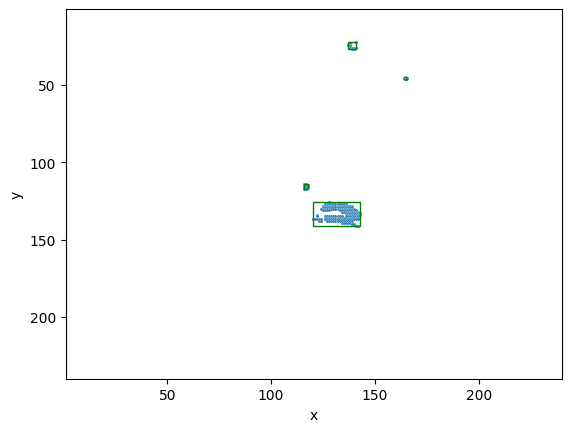

In [15]:
ax = sns.scatterplot(points, y='y', x='x', s=5)
ax.invert_yaxis()
ax.set_xlim(1, 240)
ax.set_ylim(240, 1)

for (i,r) in ybox_df.iterrows():
    if r['minx'] == r['maxx'] and r['miny'] == r['maxy']:
        mypatch = patches.Circle((r['minx'], r['miny']), radius=1)
        mypatch.set(color='green', fill=False)
    else:
        base_point = (r['minx'], r['miny'])
        width = r['maxx'] - r['minx']
        height = r['maxy'] - r['miny']
        mypatch = patches.Rectangle(base_point, width, height)
        mypatch.set(color='green', fill=False)
    ax.add_patch(mypatch)

## Only X rectangles

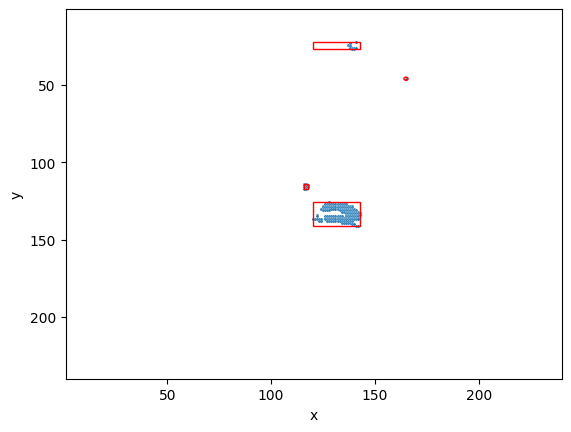

In [16]:
ax = sns.scatterplot(points, y='y', x='x', s=5)
ax.invert_yaxis()
ax.set_xlim(1, 240)
ax.set_ylim(240, 1)

for (i,r) in xbox_df.iterrows():
    if r['minx'] == r['maxx'] and r['miny'] == r['maxy']:
        mypatch = patches.Circle((r['minx'], r['miny']), radius=1)
        mypatch.set(color='red', fill=False)
    else:
        base_point = (r['minx'], r['miny'])
        width = r['maxx'] - r['minx']
        height = r['maxy'] - r['miny']
        mypatch = patches.Rectangle(base_point, width, height)
        mypatch.set(color='red', fill=False)
    ax.add_patch(mypatch)

## Intersected rectangles

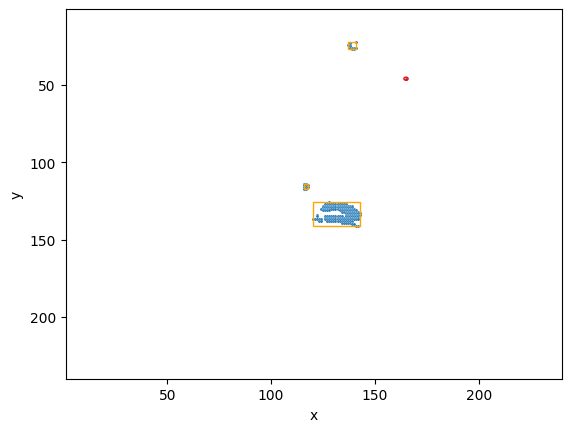

In [17]:
ax = sns.scatterplot(points, y='y', x='x', s=5)
ax.invert_yaxis()
ax.set_xlim(1, 240)
ax.set_ylim(240, 1)

for mr in overlaps:
    if mr.tlx == mr.brx and mr.tly == mr.bry:
        mypatch = patches.Circle((mr.tlx, mr.tly), radius=1)
        mypatch.set(color='red', fill=False)
    else:
        base_point = (mr.tlx, mr.tly)
        width = mr.brx - mr.tlx
        height = mr.bry - mr.tly
        mypatch = patches.Rectangle(base_point, width, height)
        mypatch.set(color='orange', fill=False)
    ax.add_patch(mypatch)